### 1. Preparing the data

Import the used library for training dataset and connect to Google Drive


In [1]:
import os
import zipfile
from os import listdir
from matplotlib import image
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import top_k_categorical_accuracy


In [2]:
from google.colab import drive
drive.mount('Mydrive')

Drive already mounted at Mydrive; to attempt to forcibly remount, call drive.mount("Mydrive", force_remount=True).


In [3]:
pwd

'/content'

#### **Unzip the dataset and define few preprocessing steps**

In [4]:
local_zip = '/content/Mydrive/MyDrive/Colab Notebooks/AML_Project/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

local_zip = '/content/Mydrive/MyDrive/Colab Notebooks/AML_Project/test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Define a normalization function

In [5]:
IMG_SIZE_ARRAY = (160, 160)
def _normalize_img(img):
    img = tf.cast(img, tf.float32)/255.   # All images will be rescaled by 1./255
    img = tf.image.resize(img, IMG_SIZE_ARRAY, method= 'bilinear')
    return (img)


#### **Load the train and test data in a list**
This method will load all the data into memory (RAM) before feeding it into the classifier for training. This is only possible when our dataset is small.


Create array list storing image paths and labels

In [6]:
train_info = '/content/Mydrive/MyDrive/Colab Notebooks/AML_Project/train.txt'

with open(train_info) as txt_file:
  lines = [x.strip() for x in txt_file.readlines()]

def TrainImageAndLabel():
  data = []
  for x in lines:
      temp = x.split(' ')
      img_data = image.imread('/tmp/' + temp[0])
      normalized_img = _normalize_img(img_data)
      data.append([normalized_img, int(temp[1])])
      print('> loaded %s %s with label %s' % (temp[0], normalized_img.shape, temp[1]))
  return data

train_data = TrainImageAndLabel()

> loaded train/photo/106461/154340.jpg (160, 160, 3) with label 106461
> loaded train/photo/106461/154115.jpg (160, 160, 3) with label 106461
> loaded train/photo/106461/154345.jpg (160, 160, 3) with label 106461
> loaded train/photo/106461/154119.jpg (160, 160, 3) with label 106461
> loaded train/photo/106461/154344.jpg (160, 160, 3) with label 106461
> loaded train/photo/106461/154338.jpg (160, 160, 3) with label 106461
> loaded train/photo/106461/154348.jpg (160, 160, 3) with label 106461
> loaded train/photo/106461/154341.jpg (160, 160, 3) with label 106461
> loaded train/photo/106461/154120.jpg (160, 160, 3) with label 106461
> loaded train/photo/106461/154343.jpg (160, 160, 3) with label 106461
> loaded train/photo/106461/154339.jpg (160, 160, 3) with label 106461
> loaded train/photo/106461/154337.jpg (160, 160, 3) with label 106461
> loaded train/photo/106461/154122.jpg (160, 160, 3) with label 106461
> loaded train/photo/106461/624.jpg (160, 160, 3) with label 106461
> loaded 

In [7]:
test_info = '/content/Mydrive/MyDrive/Colab Notebooks/AML_Project/groundtruth.txt'

with open(test_info) as txt_file:
  lines = [x.strip() for x in txt_file.readlines()]

def TestImageAndLabel():
  data = []
  for x in lines:
      temp = x.split(' ')
      img_data = image.imread('/tmp/' + temp[0])
      normalized_img = _normalize_img(img_data)
      data.append([normalized_img, int(temp[1])])
      print('> loaded %s %s with label %s' % (temp[0], normalized_img.shape, temp[1]))
  return data

test_data = TestImageAndLabel()

> loaded test/1745.jpg (160, 160, 3) with label 105951
> loaded test/153932.jpg (160, 160, 3) with label 106387
> loaded test/190962.jpg (160, 160, 3) with label 116853
> loaded test/193479.jpg (160, 160, 3) with label 119986
> loaded test/284716.jpg (160, 160, 3) with label 120497
> loaded test/86426.jpg (160, 160, 3) with label 121841
> loaded test/86714.jpg (160, 160, 3) with label 125412
> loaded test/87399.jpg (160, 160, 3) with label 126895
> loaded test/87526.jpg (160, 160, 3) with label 127007
> loaded test/271202.jpg (160, 160, 3) with label 127242
> loaded test/1000.jpg (160, 160, 3) with label 130657
> loaded test/1009.jpg (160, 160, 3) with label 132113
> loaded test/136.jpg (160, 160, 3) with label 13276
> loaded test/141.jpg (160, 160, 3) with label 13325
> loaded test/2127.jpg (160, 160, 3) with label 136761
> loaded test/196172.jpg (160, 160, 3) with label 141332
> loaded test/197081.jpg (160, 160, 3) with label 141336
> loaded test/198699.jpg (160, 160, 3) with label 1

In [8]:
x_train = []
y_train = []
for x,y in train_data:
  x_train.append(x)
  y_train.append(y)


In [9]:
x_test = []
y_test = []
for x,y in test_data:
  x_test.append(x)
  y_test.append(y)


In [10]:
# Convert Python List, "train_loaded_images" to numpy Arrays, "X_train"
x_train = np.array(x_train)
# Convert Python List, "test_loaded_images" to numpy Arrays, "X_test"
x_test = np.array(x_test)

# Convert Python List, "Y_train" to numpy Arrays, "Y_train"
y_train = np.array(y_train)
# Convert Python List, "Y_test" to numpy Arrays, "Y_test"
y_test = np.array(y_test)

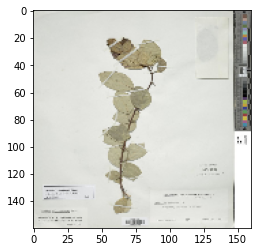

149682


In [11]:
random_value = random.randint(0, len(x_train))

plt.imshow(x_train[random_value, :])
plt.show()
print(y_train[random_value])

In [12]:
train_label = np.unique(y_train)
no_classes = train_label.size
print(no_classes)

100


In [13]:
def changeLabel():
  i=0;
  label = []
  for temp in train_label:
    label.append([temp,i])
    i += 1
  return label

new_label = changeLabel()

print(new_label)


[[12254, 0], [12518, 1], [12910, 2], [12922, 3], [13276, 4], [13325, 5], [13330, 6], [13370, 7], [14353, 8], [14401, 9], [15014, 10], [15318, 11], [15330, 12], [15355, 13], [19165, 14], [19489, 15], [29686, 16], [105951, 17], [106023, 18], [106387, 19], [106461, 20], [106466, 21], [110432, 22], [116853, 23], [119986, 24], [120497, 25], [121836, 26], [121841, 27], [125412, 28], [126895, 29], [127007, 30], [127097, 31], [127151, 32], [127242, 33], [129645, 34], [130657, 35], [131079, 36], [131736, 37], [132107, 38], [132113, 39], [132431, 40], [132476, 41], [132501, 42], [133595, 43], [133617, 44], [136761, 45], [138662, 46], [140367, 47], [141068, 48], [141332, 49], [141336, 50], [142550, 51], [142736, 52], [143496, 53], [143706, 54], [143758, 55], [144394, 56], [145020, 57], [148220, 58], [148977, 59], [149264, 60], [149682, 61], [149919, 62], [150135, 63], [151469, 64], [151593, 65], [156516, 66], [156526, 67], [158341, 68], [158592, 69], [158653, 70], [158736, 71], [158793, 72], [158

In [14]:
i =0;
for label in y_train:
  for x,y in new_label:
    if(label == x):
      y_train[i] = y
      break
  i += 1

print(y_train)

[20 20 20 ... 76 76 76]


In [15]:
j =0;
for label in y_test:
  for x,y in new_label:
    if(label == x):
      y_test[j] = y
      break
  j += 1

print(y_test)

[17 19 23 24 25 27 28 29 30 33 35 39  4  5 45 49 50 54 55  9 57 58 60 61
 10 65 12 74 75 76 20 20 20  1  1  1 32 32 32  2  2  2  3  3 36 36 36 37
 37 37 40 40 40 43 43 43 44 44 44  7  7  7 46 46 46 66 66 66 68 68 68 70
 70 70 71 71 71 73 73 73 78 78 78 80 80 80 82 82 82 83 83 83 84 84 84 85
 85 85 86 86 86 87 87 87 88 88 88 14 14 14 89 89 90 90 90 15 15 15 91 91
 91 92 92 93 93 93 94 94 94 95 95 95 96 96 96 97 97 97 98 98 98 99 99 99
 16 16 16 18 18 21 21 22 22 26 26  0  0 31 31 34 34 38 38 41 41 42 42  6
  6 47 47 48 48 51 51 52 52 53 53  8  8 56 56 59 59 62 62 63 63 64 64 11
 11 13 13 67 67 69 69 72 72 77 77 79 79 81 81]


In [16]:
print("Shape of X_train : ", x_train.shape)
print("Shape of X_test : ", x_test.shape)

print("Shape of Y_train : ", y_train.shape)
print("Shape of Y_test : ", y_test.shape)

Shape of X_train :  (4744, 160, 160, 3)
Shape of X_test :  (207, 160, 160, 3)
Shape of Y_train :  (4744,)
Shape of Y_test :  (207,)


### CNN architecture

In [17]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE_ARRAY + (3,)

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [19]:
# Normalization of preprocessing input 

def preprocess_input_mobile_net():
  return tf.keras.applications.mobilenet_v2.preprocess_input

preprocess_input = preprocess_input_mobile_net()

In [20]:
def model_mobile_net():
  return tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
            include_top=False, weights='imagenet')
  
base_model = model_mobile_net()

In [21]:
base_model.trainable = False

In [22]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [23]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [24]:
prediction_layer = tf.keras.layers.Dense(no_classes)

In [25]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0     

In [28]:
len(model.trainable_variables)

6

In [29]:
loss0, accuracy0 = model.evaluate(x_test, y_test)

7/7 [==============================] - 4s 67ms/step - loss: 4.7999 - accuracy: 0.0193


In [30]:
initial_epochs = 20

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(x_train, y_train,
                    epochs=initial_epochs,
                    batch_size = 32, validation_data=(x_test,y_test),
                    callbacks=[callback])

Epoch 1/20
149/149 [==============================] - 7s 31ms/step - loss: 4.3948 - accuracy: 0.0594 - val_loss: 4.2714 - val_accuracy: 0.1063
Epoch 2/20
149/149 [==============================] - 5s 37ms/step - loss: 3.4602 - accuracy: 0.2114 - val_loss: 4.0193 - val_accuracy: 0.1498
Epoch 3/20
149/149 [==============================] - 4s 28ms/step - loss: 2.8271 - accuracy: 0.3177 - val_loss: 3.8730 - val_accuracy: 0.2319
Epoch 4/20
149/149 [==============================] - 4s 27ms/step - loss: 2.4535 - accuracy: 0.3940 - val_loss: 3.8163 - val_accuracy: 0.2705
Epoch 5/20
149/149 [==============================] - 4s 29ms/step - loss: 2.1394 - accuracy: 0.4574 - val_loss: 3.6815 - val_accuracy: 0.3285
Epoch 6/20
149/149 [==============================] - 4s 28ms/step - loss: 1.9162 - accuracy: 0.5160 - val_loss: 3.7392 - val_accuracy: 0.3333
Epoch 7/20
149/149 [==============================] - 4s 30ms/step - loss: 1.7052 - accuracy: 0.5603 - val_loss: 3.7218 - val_accuracy: 0.3285

In [31]:
#Get the training model parameters
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

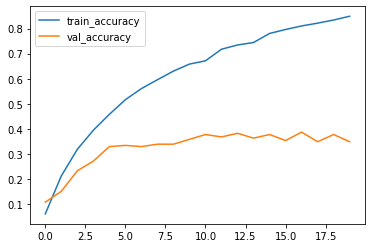

In [32]:
#Generate a accuracy graph
plt.plot(history.epoch, history.history.get("accuracy"), label = "train_accuracy")
plt.plot(history.epoch, history.history.get("val_accuracy"), label = "val_accuracy")
plt.legend()

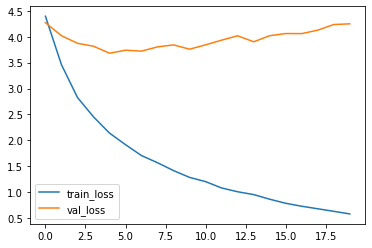

In [33]:
#Generate a loss graph
plt.plot(history.epoch, history.history.get("loss"), label = "train_loss")
plt.plot(history.epoch, history.history.get("val_loss"), label = "val_loss")
plt.legend()

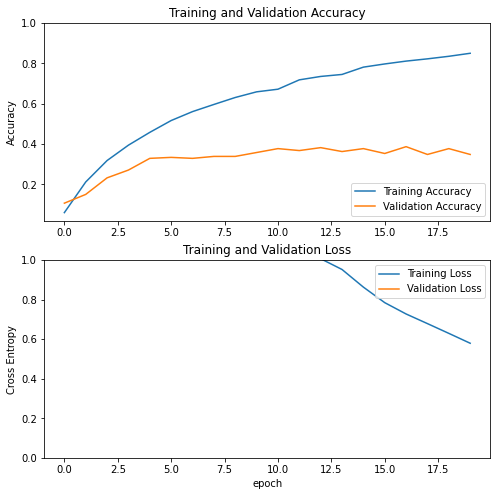

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
base_model.trainable = True

In [36]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [37]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0     

In [39]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(x_train, y_train,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    batch_size = 32,
                    validation_data=(x_test,y_test),  callbacks=[callback])

Epoch 20/40
149/149 [==============================] - 13s 48ms/step - loss: 0.4705 - accuracy: 0.8708 - val_loss: 4.5952 - val_accuracy: 0.3671
Epoch 21/40
149/149 [==============================] - 6s 42ms/step - loss: 0.4050 - accuracy: 0.8940 - val_loss: 4.6240 - val_accuracy: 0.3720
Epoch 22/40
149/149 [==============================] - 6s 42ms/step - loss: 0.3558 - accuracy: 0.9068 - val_loss: 4.6694 - val_accuracy: 0.3671
Epoch 23/40
149/149 [==============================] - 7s 44ms/step - loss: 0.3249 - accuracy: 0.9182 - val_loss: 5.0005 - val_accuracy: 0.3478
Epoch 24/40
149/149 [==============================] - 6s 42ms/step - loss: 0.2977 - accuracy: 0.9277 - val_loss: 4.7399 - val_accuracy: 0.3623
Epoch 25/40
149/149 [==============================] - 6s 42ms/step - loss: 0.2733 - accuracy: 0.9309 - val_loss: 4.8285 - val_accuracy: 0.3816
Epoch 26/40
149/149 [==============================] - 6s 42ms/step - loss: 0.2486 - accuracy: 0.9406 - val_loss: 4.8352 - val_accuracy

In [40]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

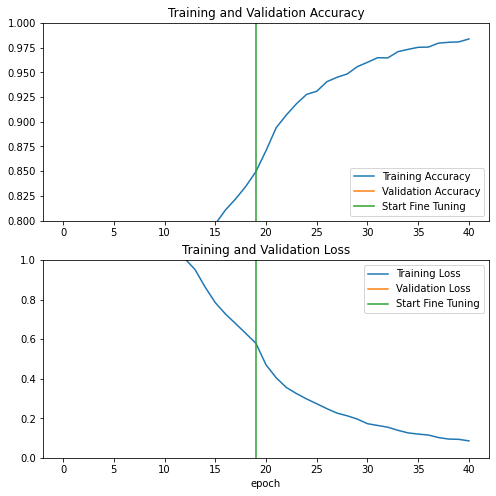

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:0.9837689995765686\nValidation Accuracy: 0.3913043439388275')

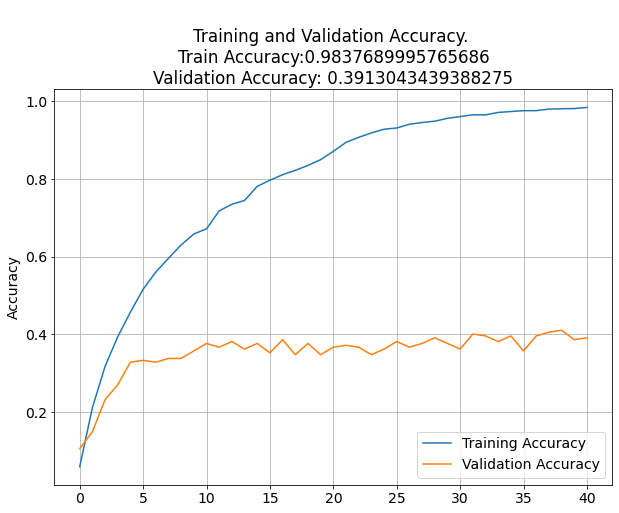

In [42]:
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

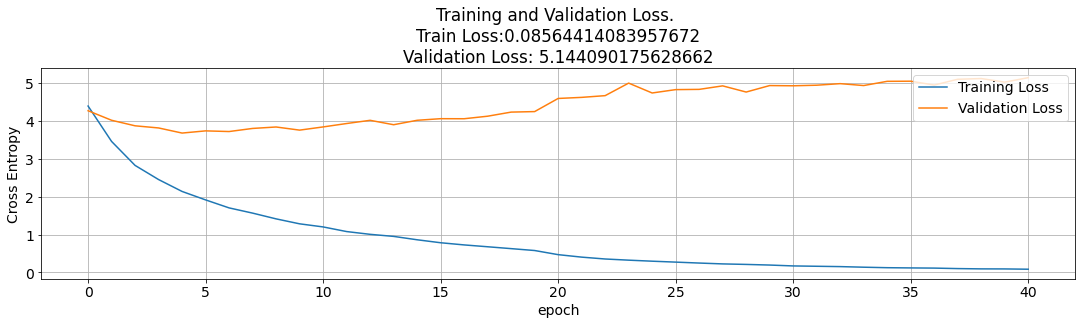

In [43]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [44]:
accuracy_score = model.evaluate(x_test, y_test)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])

7/7 [==============================] - 0s 34ms/step - loss: 5.1441 - accuracy: 0.3913
[5.144090175628662, 0.3913043439388275]
Accuracy: 39.1304%
Loss:  5.144090175628662


In [45]:
model.save("AML_MobileNet.h5")